In [2]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import math
import xgboost
import xgboost as xgb
import pickle
import duckdb

In [6]:
from binding_prediction.const import WHOLE_MOLECULE_COLUMN, TARGET_COLUMN

from binding_prediction.datasets.xgboost_iterator import SmilesIterator

from binding_prediction.evaluation.kaggle_submission_creation import get_submission_test_predictions_for_xgboost_model


# EDA

## Get train dataset info

In [3]:
train_path = 'data/train.parquet'
test_path = 'data/test.parquet'

In [4]:
parquet_file = pq.ParquetFile('data/train.parquet')

In [5]:
parquet_file.metadata

  created_by: parquet-cpp-arrow version 14.0.2
  num_columns: 7
  num_rows: 295246830
  num_row_groups: 282
  format_version: 2.6
  serialized_size: 291416

In [6]:
row_group_0 = parquet_file.read_row_group(0)
row_group_1 = parquet_file.read_row_group(1)

combined_table = pa.concat_tables([row_group_0, row_group_1])
pq.write_table(row_group_0, 'data/row_group_0.parquet')
pq.write_table(combined_table, 'data/two_row_groups.parquet')


In [ ]:
for i in range(parquet_file.metadata.num_row_groups):
    row_group_stats = parquet_file.metadata.row_group(i).column(0).statistics
    print(f"row group: {i}, num of rows: {row_group_stats.num_values}")

### Create subsample of train dataset to experiment with it

In [18]:
# https://www.kaggle.com/code/andrewdblevins/leash-tutorial-ecfps-and-random-forest
con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 1500)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 789)""").df()
df = df.sample(frac=1).reset_index(drop=True)
arrow_table = pa.Table.from_pandas(df)
pq.write_table(arrow_table, 'tests/test_data/train.parquet', row_group_size=500)

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
row_group_df = parquet_file.read_row_group(0).to_pandas()
row_group_df.to_csv('data/row_group_0.csv')

In [ ]:
row_group_df.info()

### Get statistics of the target column

In [ ]:
negative_count = 0
positive_count = 0
for i in range(parquet_file.metadata.num_row_groups):
    row_group_df = parquet_file.read_row_group(i).to_pandas()
    negative_count += row_group_df[TARGET_COLUMN].value_counts()[0]
    positive_count += row_group_df[TARGET_COLUMN].value_counts()[1]
    print(f"row group: {i}, negative count: {negative_count}, positive count: {positive_count}")

In [ ]:
_ = plt.bar(['log negative', 'log positive'], [np.log(negative_count), np.log(positive_count)])
_ = plt.title('Target column distribution')

### Draw couple of molecules

In [ ]:
row_group_df = parquet_file.read_row_group(0).to_pandas()

In [ ]:
row_group_df[WHOLE_MOLECULE_COLUMN].head()

In [ ]:
smiles = []
targets = []
for i in tqdm(range(parquet_file.metadata.num_row_groups)):
    row_group_df = parquet_file.read_row_group(i).to_pandas()
    negative_sample = row_group_df[row_group_df[TARGET_COLUMN] == 0].sample(2)
    positive_sample = row_group_df[row_group_df[TARGET_COLUMN] == 1].sample(2)
    subsample = pd.concat([negative_sample, positive_sample])
    smiles.extend(subsample[WHOLE_MOLECULE_COLUMN].values)
    targets.extend(subsample[TARGET_COLUMN].values)

In [ ]:
num_mols_to_draw = 100
random_indices = np.random.choice(len(smiles), num_mols_to_draw, replace=False)
grid_size = math.ceil(np.sqrt(num_mols_to_draw))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i in tqdm(range(num_mols_to_draw)):
    smile = smiles[random_indices[i]]
    target = targets[random_indices[i]]
    mol = Chem.MolFromSmiles(smile)
    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(Draw.MolToImage(mol))
    ax.set_title(f'target: {target}')
ax.axis('off')

# XGBoost baseline

In [ ]:
print('Train validation split')
train_file_path = 'data/row_group_0.parquet'
rng = np.random.default_rng(seed=42)

train_val_pq = pq.ParquetFile(train_file_path)
train_indices = rng.choice(train_val_pq.metadata.num_rows, int(0.8 * train_val_pq.metadata.num_rows), replace=False)
val_indices = np.setdiff1d(np.arange(train_val_pq.metadata.num_rows), train_indices)

print('Creating datasets')
train_dataset = SmilesIterator(train_file_path, indicies=train_indices, radius=3, test_set=False)
val_dataset = SmilesIterator(train_file_path, indicies=val_indices, radius=3, test_set=False)
test_dataset = SmilesIterator('data/test.parquet', shuffle=False, radius=3, test_set=True)

In [ ]:
train_Xy = xgboost.DMatrix(train_dataset)

In [ ]:
val_Xy = xgboost.DMatrix(val_dataset)

In [ ]:
test_Xy = xgboost.DMatrix(test_dataset)

In [ ]:
print('Load model')
model_path = 'logs/2024-04-25_22-04-59/model.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)
    

In [ ]:
print('Predicting')
get_submission_test_predictions(test_dataset, test_Xy, model, 'logs/2024-04-25_22-04-59')

In [ ]:
print('Creating model')
params = {
    'max_depth': 10,
    'objective': 'binary:logistic',
    # 'nthread': 4,
    'eval_metric': 'auc',
    'verbosity': 2
}


num_rounds = 10  # equivalent to the number of estimators

eval_list = [(train_Xy, 'train'), (val_Xy, 'eval')]  # evaluation set for monitoring

In [ ]:
model = xgb.train(params, train_Xy, num_rounds, evals=eval_list, verbose_eval=100000)

In [ ]:
# Save the model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [3]:
sub = pd.read_csv("submission.csv")

<Axes: >

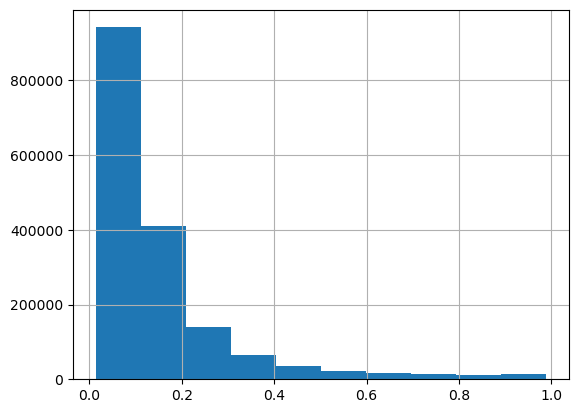

In [4]:
sub[TARGET_COLUMN].hist()

In [3]:
sub_bad = pd.read_csv("logs/2024-05-11_10-10-44/submission.csv")

<Axes: >

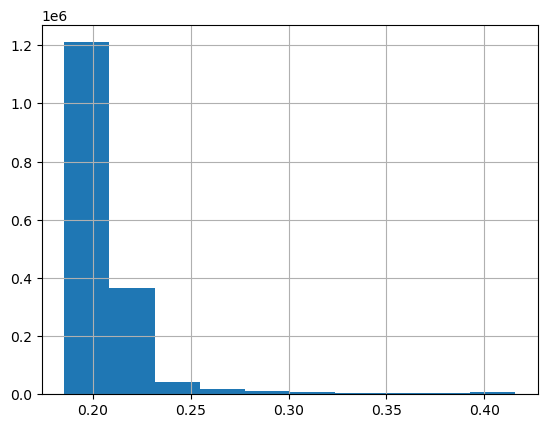

In [4]:
sub_bad[TARGET_COLUMN].hist()

In [5]:
val_ind = np.load("logs/2024-05-09_20-13-18/val_indices.npy")

In [12]:
val_targets = []
parquet_file = pq.ParquetFile('data/train.parquet')
shard_size = parquet_file.metadata.row_group(0).num_rows
for i in tqdm(range(parquet_file.metadata.num_row_groups)):
    val_ind_in_row_group = list(filter(lambda x: i * shard_size < x < (i + 1) * shard_size, val_ind))
    relative_val_ind = np.array(val_ind_in_row_group) - i * shard_size
    if len(relative_val_ind) == 0:
        continue
    row_group_df = parquet_file.read_row_group(i).to_pandas()
    val_targets.extend(row_group_df.iloc[relative_val_ind][TARGET_COLUMN].values)

100%|██████████| 14/14 [01:02<00:00,  4.46s/it]


(array([2926965.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,    8558.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

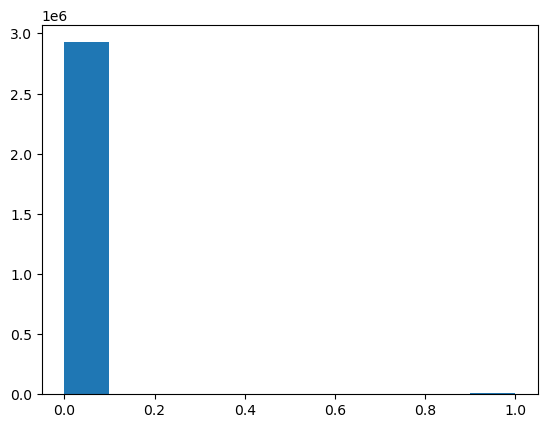

In [13]:
plt.hist(val_targets)

In [15]:
val_dataset = SmilesIterator("data/train.parquet", indicies=val_ind, pq_row_group_numbers=list(range(14)),
                                         fingerprint='circular_fingerprint',
                                         radius=3,
                                         nBits=1024,
                                         protein_map_path="data/processed/train.parquet/circular_fingerprint_3_1024/protein_map.json")

val_Xy = xgboost.DMatrix(val_dataset)

Reading row group 0
Number of indicies in shard 210298
Processing row group 0
Reading time: 1.5333104133605957
Protein encoding time: 0.09265398979187012
Fingerprinting time: 73.85886597633362
Combining time: 9.40910816192627
Fingerprinting time 84.95230007171631
Inputting data
Inputting time 0.0031511783599853516
Reading row group 1
Number of indicies in shard 210101
Processing row group 1
Reading time: 1.686682939529419
Protein encoding time: 0.0821220874786377
Fingerprinting time: 81.26919388771057
Combining time: 9.934137105941772
Fingerprinting time 93.1099169254303
Inputting data
Inputting time 0.19609999656677246
Reading row group 2
Number of indicies in shard 208640
Processing row group 2
Reading time: 1.2865779399871826
Protein encoding time: 0.07173871994018555
Fingerprinting time: 55.13709115982056
Combining time: 8.358207941055298
Fingerprinting time 64.91453909873962
Inputting data
Inputting time 0.22532105445861816
Reading row group 3
Number of indicies in shard 209297
Pr

In [16]:
with open('logs/2024-05-09_20-13-18/model_37.pkl', 'rb') as file:
    model = pickle.load(file)

(array([3490076., 1381352.,  334968.,  135529.,   99199.,   85668.,
          55521.,   40864.,   26658.,   12476.]),
 array([0.07947747, 0.16324629, 0.2470151 , 0.33078393, 0.41455275,
        0.49832156, 0.58209038, 0.66585916, 0.74962801, 0.83339679,
        0.91716564]),
 <BarContainer object of 10 artists>)

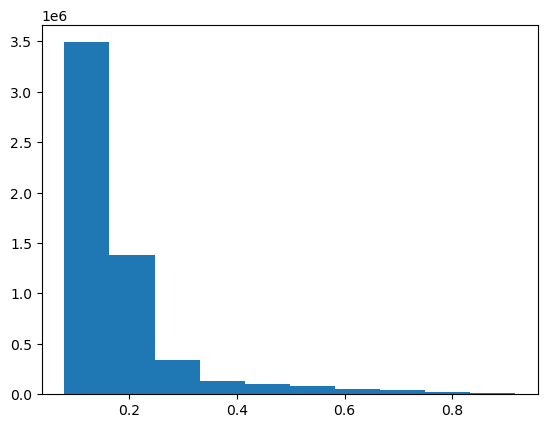

In [17]:
val_predictions = model.predict(val_Xy)
plt.hist(val_predictions)

(array([2407962., 2147462.,  585816.,  164823.,  104051.,   98860.,
          64233.,   34213.,   44169.,   10722.]),
 array([0.24597871, 0.29930717, 0.35263565, 0.40596411, 0.45929259,
        0.51262105, 0.5659495 , 0.61927795, 0.67260647, 0.72593492,
        0.77926338]),
 <BarContainer object of 10 artists>)

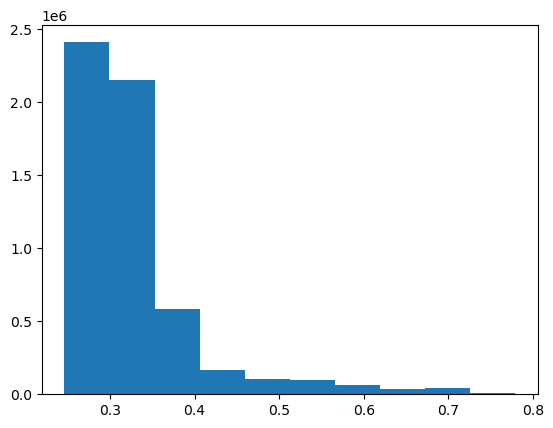

In [18]:
with open('logs/2024-05-09_20-13-18/model_14.pkl', 'rb') as file:
    model = pickle.load(file)
val_predictions = model.predict(val_Xy)
plt.hist(val_predictions)

In [19]:
test_dataset = SmilesIterator("data/test.parquet", shuffle=False,
                                         fingerprint='circular_fingerprint',
                                         radius=3,
                                         nBits=1024,
                                         protein_map_path="data/processed/protein_map.json")
test_Xy = xgboost.DMatrix(test_dataset)

Reading row group 0
Number of indicies in shard 1048576
Processing row group 0
Reading time: 1.044287919998169
Protein encoding time: 0.25345396995544434
Fingerprinting time: 517.9607810974121
Combining time: 53.832345962524414
Fingerprinting time 573.1600019931793
Inputting data
Inputting time 0.04524397850036621
Reading row group 1
Number of indicies in shard 626320
Processing row group 1
Reading time: 1.1136350631713867
Protein encoding time: 0.21134209632873535
Fingerprinting time: 363.24027490615845
Combining time: 24.20472025871277
Fingerprinting time 388.8549630641937
Inputting data
Inputting time 0.8499977588653564


(array([ 66136.,  81904.,  99136., 149306., 225775., 204408., 129986.,
         89275., 221397., 407573.]),
 array([0.25105873, 0.3059141 , 0.36076951, 0.41562492, 0.47048029,
        0.52533567, 0.58019108, 0.63504648, 0.68990183, 0.74475724,
        0.79961264]),
 <BarContainer object of 10 artists>)

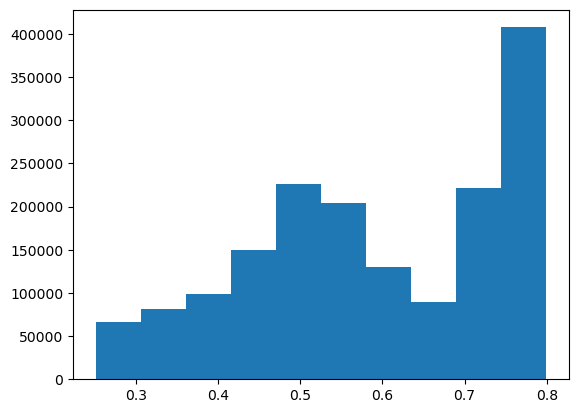

In [20]:
test_predictions = model.predict(test_Xy)
plt.hist(test_predictions)